In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction

In this notebook, we are going to treat US poiticians' twitter accounts as the nodes and mentions of them by each other as edges. Let's see what we can learn about the US politicians' twitter.

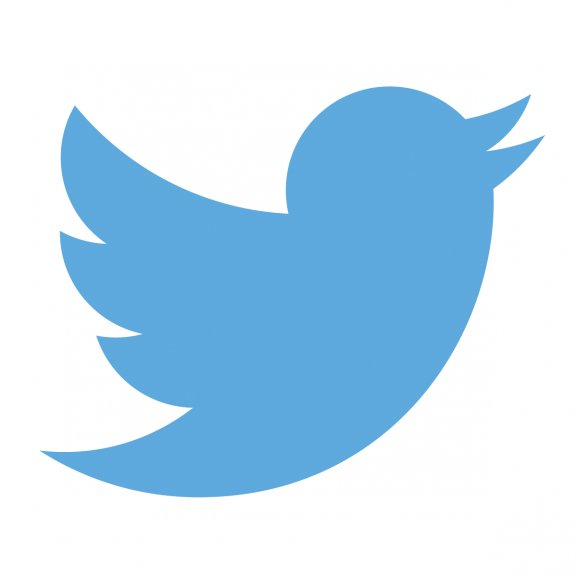

# Dependencies

In [4]:
import pandas as pd #dataframes
import numpy as no #mathematical operations
import networkx as nx #network analysis
import seaborn as sns #visualisation
import matplotlib.pyplot as plt
import gc #collecting garbage
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator #visualisation
sns.set_theme(context='notebook', style='whitegrid', palette='vlag', font='serif')

# EDA

In [7]:
# df = pd.read_csv('/kaggle/input/us-politicians-twitter-dataset/dataset.csv',parse_dates=['Account_start_time','Birthday'])
df = pd.read_csv('scrape_twitter_uspol_dataset.csv',parse_dates=['Account_start_time','Birthday'])
df.head()

,Name,Twitter_username,Account_start_time,Account_ID,Sex,Birthplace,Birthday,Age,Instagram_username,Political_party
0,A. Donald McEachin,RepMcEachin,2017-01-03 00:00:00+00:00,816181091673448448,male,Germany,1961-10-10 00:00:00+00:00,59.0,repmceachin,Democratic Party
1,Aaron Michlewitz,RepMichlewitz,2010-06-27 00:00:00+00:00,160246973,male,United States of America,1978-01-01 00:00:00+00:00,42.0,NaN,Democratic Party
2,Aaron Peskin,AaronPeskin,2010-11-13 00:00:00+00:00,215369273,male,United States of America,1964-06-17 00:00:00+00:00,56.0,apeskin52,Democratic Party
3,Aaron Peña,AaronPena,2007-10-31 00:00:00+00:00,9843332,male,United States of America,1959-06-08 00:00:00+00:00,61.0,NaN,Republican Party
4,Aaron Schock,aaronschock,2009-03-12 00:00:00+00:00,23951197,male,United States of America,1981-05-28 00:00:00+00:00,39.0,aaronschock,Republican Party


In [8]:
df.isna().sum()

Name                     0
Twitter_username         0
Account_start_time     391
Account_ID             331
Sex                      0
Birthplace               1
Birthday                23
Age                     23
Instagram_username    1347
Political_party          0
dtype: int64

**What is the gender ratio in the dataset?**

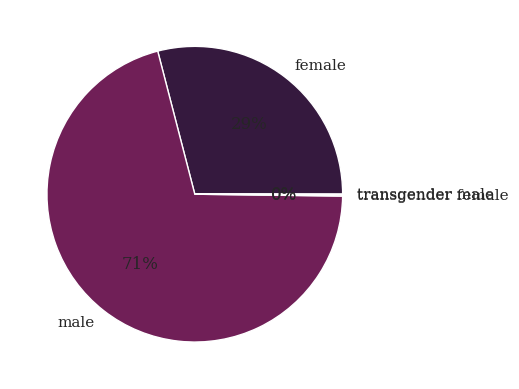

In [9]:
colors = sns.color_palette('rocket')[0:4]
data = df.groupby('Sex').size().reset_index()
plt.pie(data[0], labels=data['Sex'], colors = colors, autopct='%.0f%%')
plt.show()

**How old are the US politicians presented in the dataset? Is there any relation between gender/sex and the age?**

Mean age sex male: 59.34258210645527 
Mean age sex female: 57.32361111111111 
Mean age sex transgender male: 38.0 
Mean age sex transgender female: 51.25


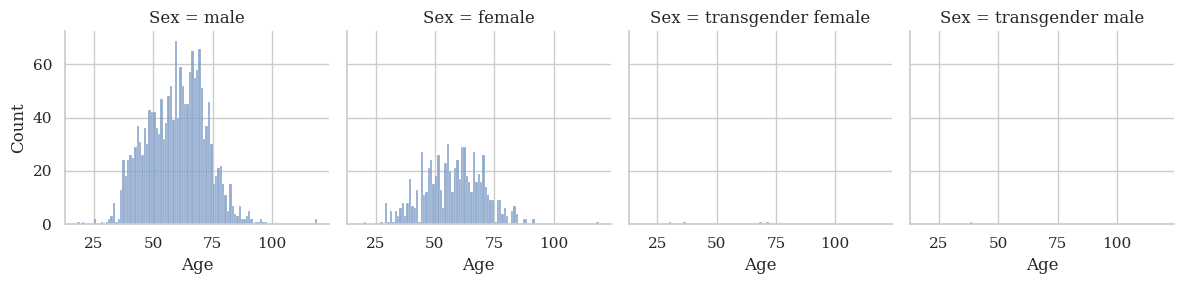

In [10]:
fig = sns.displot(
    df, x="Age", col="Sex",
    binwidth=1, height=3,
)
print('Mean age sex male:',df[df.Sex=='male'].Age.mean(),'\nMean age sex female:',df[df.Sex=='female'].Age.mean(),'\nMean age sex transgender male:',df[df.Sex=='transgender male'].Age.mean(),'\nMean age sex transgender female:',df[df.Sex=='transgender female'].Age.mean())

**Which political parties members are presented in the dataset?**

In [11]:
print('Number of parties', len(df.Political_party.unique()),'\n')
print(df.Political_party.value_counts())

Number of parties 80 

Democratic Party                           1232
Republican Party                           1068
California Democratic Party                  25
Minnesota Democratic–Farmer–Labor Party      23
independent politician                       22
                                           ... 
Colombian Liberal Party                       1
Panhellenic Socialist Movement                1
Oregon Republican Party                       1
Liberal Party of New York                     1
Likud                                         1
Name: Political_party, Length: 80, dtype: int64


    Political_party     0
0  Democratic Party  1232
1             Other   214
2  Republican Party  1068


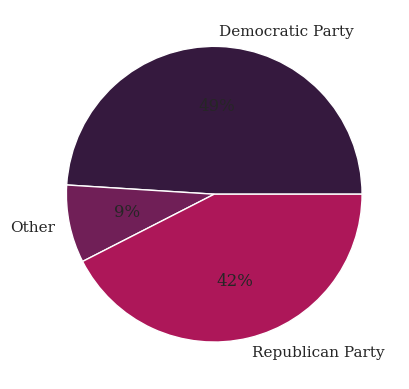

3438

In [12]:
data = df.copy()
data.loc[(data['Political_party']!= 'Democratic Party') & (data['Political_party']!='Republican Party'), 'Political_party'] = 'Other'
data = data.groupby('Political_party').size().reset_index()
print(data)
colors = sns.color_palette('rocket')[0:4]
plt.pie(data[0], labels=data['Political_party'], autopct='%.0f%%', colors=colors)
plt.show()
gc.collect()

**What are top birth places of the politicians present in the dataset?**

In [13]:
df.Birthplace.value_counts()

United States of America      2366
Germany                         17
Somalia                          9
Guatemala                        8
Colombia                         8
Mexico                           8
India                            8
Empire of Japan                  7
Taiwan                           7
Japan                            6
Cuba                             6
Canada                           6
United Kingdom                   5
Peru                             5
Spain                            5
South Korea                      4
Pakistan                         4
Switzerland                      3
Dominican Republic               3
Philippines                      3
Italy                            2
Vietnam                          2
Thailand                         2
Netherlands                      2
Venezuela                        1
France                           1
Czech Republic                   1
Cambodia                         1
Puerto Rico         

For convenience, let's replace all the other countries with 'Other'

                 Birthplace     0
0                     Other   148
1  United States of America  2366


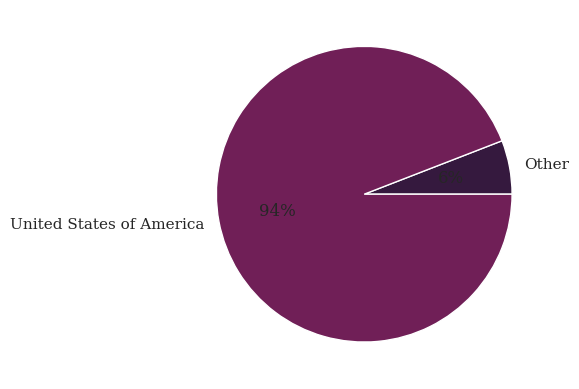

2514

In [14]:
data = df.copy()
data.loc[(data['Birthplace']!= 'United States of America') & (data['Birthplace']!='United States of America'), 'Birthplace'] = 'Other'
data = data.groupby('Birthplace').size().reset_index()
print(data)
plt.pie(data[0], labels=data['Birthplace'], autopct='%.0f%%',colors=colors)
plt.show()
gc.collect()

**What are top surnames among the politicians listed in the dataset?**

In [15]:
df['Surname'] = df['Name'].apply(lambda x:x.split(' ')[-1])
df['Surname']

0         McEachin
1       Michlewitz
2           Peskin
3             Peña
4           Schock
           ...    
2509        Clarke
2510       Herrell
2511      Teachout
2512       Lofgren
2513        Istvan
Name: Surname, Length: 2514, dtype: object

In [16]:
print('Total number of surnames', len(df.Surname.unique()))
print(f'Ratio surnames presented in the dataset:people presented in the dataset: {len(df.Surname.unique())}:{df.shape[0]}')

Total number of surnames 1472
Ratio surnames presented in the dataset:people presented in the dataset: 1472:2514


Top surnames
      Surname  frequency
0       Smith         28
1         Jr.         24
2     Johnson         17
3      Murphy         13
4       Pence         13
...       ...        ...
1467    Comer          1
1468   Allsup          1
1469  Beutler          1
1470     Frey          1
1471   Istvan          1

[1472 rows x 2 columns]
Distribution of surname frequencies


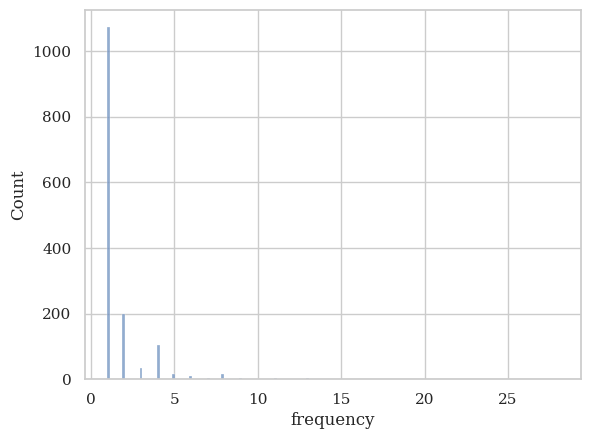

In [17]:
print('Top surnames')
data = df.Surname.value_counts().reset_index().rename(columns={'index':'Surname', 'Surname': 'frequency'})
print(data)
print('Distribution of surname frequencies')
sns.histplot(data.frequency)
plt.show()

Top-20 surnames


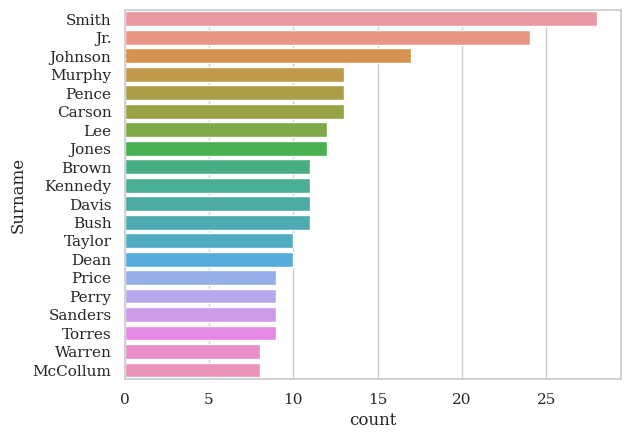

In [18]:
sns.countplot(y="Surname", data=df,order=df.Surname.value_counts().iloc[:20].index)
print("Top-20 surnames")

**When were most of the accounts in the dataset created?**

<AxesSubplot: xlabel='Account_start_time', ylabel='Count'>

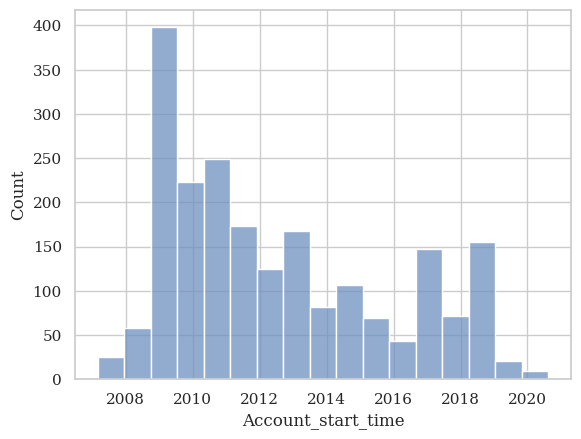

In [19]:
sns.histplot(df.Account_start_time)

***Is there any relation between gender/sex and being a member of certain political party?*****

Political_party  Sex               
Democratic       female                483
                 male                  745
                 transgender female      3
                 transgender male        1
Other            female                 82
                 male                  131
                 transgender female      1
Republican       female                165
                 male                  903
dtype: int64


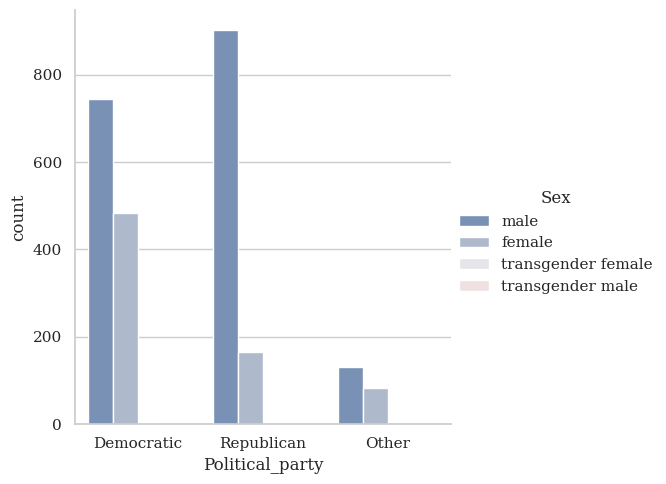

In [20]:
df.loc[(df['Political_party']!= 'Democratic Party') & (df['Political_party']!='Republican Party'), 'Political_party'] = 'Other'
df.loc[(df['Political_party'] == 'Democratic Party'), 'Political_party'] = 'Democratic'
df.loc[(df['Political_party'] == 'Republican Party'), 'Political_party'] = 'Republican'

sns.catplot(x="Political_party", hue="Sex", data=df, kind="count")

print(df.groupby(['Political_party','Sex']).size())

**What is the most common month of birth among these politicians?**

<AxesSubplot: xlabel='Birthday', ylabel='Count'>

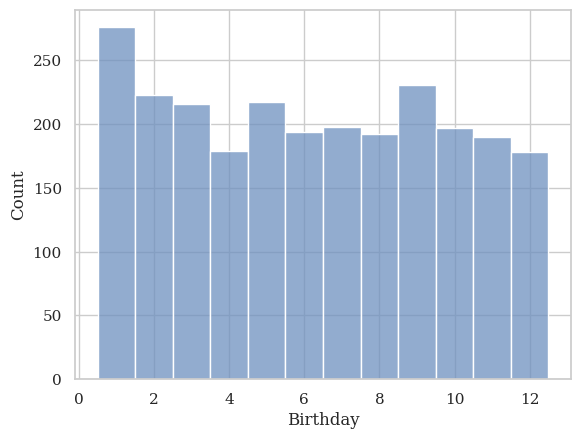

In [21]:
sns.histplot(df.Birthday.apply(lambda x: x.month),discrete=True)

The distribution is approximately uniform!

# Feature engineering

Now we can go to the next step and collect the features we need for the network analysis.

In [22]:
# ! pip install tweepy #let's install the Twitter API scrapper
import tweepy

In [23]:
#US politicians tweets dataframe: text - text content of the tweet, author - the creator of the tweet, political party - political party of the tweet sender,
#reply_to - to whose tweet this tweet replies (if any).
us_tweets = pd.DataFrame(columns=['text', 'author', 'political_party', 'reply_to', 'user_mentions','retweet_count', 'favorite_count', 'created_at'])

**Let's start the API**

In [24]:
import config_twitter

secret_label = 'your-secret-label'
api_key = config_twitter.API_KEY
secret_api_key = config_twitter.API_KEY_SECRET
access_token = config_twitter.ACCESS_TOKEN
access_token_secret = config_twitter.ACCESS_TOKEN_SECRET
auth = tweepy.OAuthHandler(api_key, secret_api_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)
count = 0
error = 0

**Let's collect tweets!**

In [25]:
%%time

# NOTE: 21m42s 06:40AM-EST Mon 20221031 Laptop/Bad Internet

def get_user_tweets(username, political_party):
   global api, us_tweets,count,error
   count+=1
   try:
        tweets = api.user_timeline(screen_name=username, 
                           include_rts = False,
                           tweet_mode = 'extended',
                           )
        table = [[tweet._json['full_text'],username, political_party, tweet._json['in_reply_to_user_id'],tweet._json['entities']['user_mentions'],tweet._json['retweet_count'], tweet._json['favorite_count'],tweet._json['created_at']] for  tweet in tweets]
        df = pd.DataFrame(table)
        df.columns = ['text', 'author', 'political_party','reply_to', 'user_mentions','retweet_count', 'favorite_count', 'created_at']
        us_tweets = us_tweets.append(df)
   except:
        error+=1
        print(error, count)
        if count%100==True:
            print(count)
df.apply(lambda x:get_user_tweets(x.Twitter_username, x.Political_party),axis=1)
gc.collect()

C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

1 38


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

2 49


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

3 71
4 72


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

5 86


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

6 105


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


7 108


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


8 110


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


9 115


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


10 117


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

11 123


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


12 125


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

13 132


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

14 150


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


15 152


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


16 154


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


17 156


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

18 194
19 195
20 196
21 197
22 198


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

23 225


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


24 227


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


25 229


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


26 231


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

27 251


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


28 253


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

29 263


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


30 268
31 269


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


32 273


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

33 282


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


34 286


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


35 291
36 292


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

37 303


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


38 305


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

39 318


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


40 320


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

41 327
42 328
43 329
44 330


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

45 343


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

46 360


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

47 373


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

48 381


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


49 383


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

50 396


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


51 399
52 400


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


53 402


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


54 407


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


55 409


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

56 429
57 430
58 431


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

59 448
60 449


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

61 499
62 500


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

63 515


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


64 520


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

65 527
66 528


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

67 539


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


68 541


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

69 560


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


70 562


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

71 570


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


72 574
73 575
74 576
75 577
76 578


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

77 600


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

78 607


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


79 611


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


80 613


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

81 627


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


82 629


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

83 641


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


84 645


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


85 647


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

86 665


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


87 668


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

88 678


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


89 680


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

90 688
91 689
92 690


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


93 693


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

94 707
95 708


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

96 760
97 761
98 762


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

99 795
100 796


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


101 798
102 799


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


103 801
801


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

104 808
105 809


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

106 820


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


107 822


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

108 829


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

109 835


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

110 847


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


111 849


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


112 852
113 853


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

114 864


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


115 866


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


116 868


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


117 871


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


118 873


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


119 876


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

120 916


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


121 918


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

122 947


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

123 957


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

124 968


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

125 997


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


126 999


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


127 1004


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

128 1012


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


129 1014


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

130 1031


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

131 1053


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


132 1058


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

133 1064
134 1065
135 1066
136 1067


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

137 1100


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


138 1102
139 1103


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


140 1106


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


141 1111


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

142 1129


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


143 1133


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

144 1139
145 1140


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

146 1161


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


147 1163


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

148 1172


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


149 1177
150 1178


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

151 1191


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

152 1207


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

153 1222


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

154 1235


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


155 1239


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


156 1243


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

157 1279


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


158 1283


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

159 1299


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

160 1308


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

161 1327
162 1328
163 1329
164 1330


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


165 1333


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

166 1347


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


167 1351
168 1352


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


169 1355


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


170 1360


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

171 1390
172 1391
173 1392
174 1393


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


175 1396


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

176 1408


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

177 1420


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

178 1439


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


179 1442
180 1443


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

181 1455


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

182 1462
183 1463
184 1464
185 1465
186 1466
187 1467
188 1468
189 1469


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

190 1487


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


191 1489
192 1490


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

193 1496


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
Rate limit reached. Sleeping for: 366
C:\Users\jonch\AppData\Loc

194 1511
195 1512


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

196 1552


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

197 1584


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

198 1598
199 1599


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


200 1601
1601


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


201 1603


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


202 1608


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

203 1624
204 1625


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


205 1629


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

206 1638
207 1639


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


208 1644
209 1645


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


210 1648


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

211 1661


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

212 1669
213 1670


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

214 1681


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

215 1691


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

216 1698


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

217 1704


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

218 1737


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

219 1755


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

220 1761


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

221 1767
222 1768


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

223 1774
224 1775
225 1776


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

226 1816


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


227 1819


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

228 1844
229 1845


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


230 1850


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

231 1862
232 1863


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

233 1869


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

234 1879


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

235 1889


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

236 1944


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

237 1961
238 1962


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


239 1965


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

240 1973


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

241 1979


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

242 1989


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

243 1998


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

244 2011


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


245 2016


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


246 2021
247 2022


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

248 2043


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

249 2052


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


250 2054


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

251 2073


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

252 2092


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

253 2104


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


254 2109


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


255 2111


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


256 2116


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


257 2119
258 2120


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

259 2143


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

260 2151


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


261 2153


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


262 2155


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


263 2158


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


264 2163


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

265 2176


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


266 2178


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

267 2193
268 2194


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

269 2205


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


270 2208


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

271 2216


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


272 2219


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

273 2240
274 2241
275 2242
276 2243


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

277 2263
278 2264


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


279 2266


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

280 2279


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


281 2281


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

282 2298
283 2299
284 2300
285 2301
2301


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

286 2315


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

287 2329


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

288 2335


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

289 2352


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

290 2363


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

291 2391


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

292 2411


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

293 2428


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

294 2456


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

295 2471
296 2472


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

297 2478


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


298 2480


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

299 2488


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

300 2501
2501


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


301 2503


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


302 2506
303 2507


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)


304 2509


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_tweets = us_tweets.append(df)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\198841404.py:12

12259

In [26]:
us_tweets.to_csv('scrape_twitter_uspols_ustweets.csv', index=False)

**Let's make an overview of the collected messages!**

Which author do most tweets in the dataset belong to?

Top-20 authors


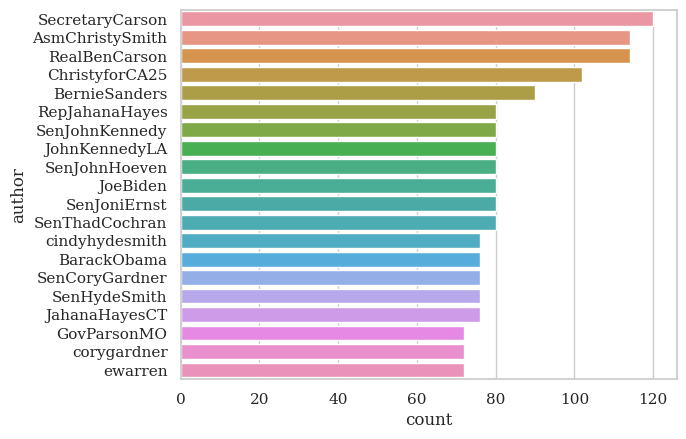

In [27]:
sns.countplot(y="author", data=us_tweets,order=us_tweets.author.value_counts().iloc[:20].index)
print("Top-20 authors")
plt.show()

**What are the most popular tweets in the dataset?**

In [28]:
top_retweeted = us_tweets.sort_values('retweet_count', ascending=False).head(10)
top_retweeted

,text,author,political_party,reply_to,user_mentions,retweet_count,favorite_count,created_at
1,Being your First Lady has been the honor of a ...,FLOTUS44,Democratic,None,[],304126,1021856,Thu Jan 19 00:12:26 +0000 2017
1,Being your First Lady has been the honor of a ...,FLOTUS44,Democratic,None,[],304126,1021856,Thu Jan 19 00:12:26 +0000 2017
7,So proud of @POTUS and all that we've accompli...,FLOTUS44,Democratic,None,"[{'screen_name': 'POTUS', 'name': 'President B...",129949,431305,Wed Jan 11 03:30:26 +0000 2017
7,So proud of @POTUS and all that we've accompli...,FLOTUS44,Democratic,None,"[{'screen_name': 'POTUS', 'name': 'President B...",129949,431305,Wed Jan 11 03:30:26 +0000 2017
3,Look at this Mark \n\nHow you gone kick me off...,kanyewest,Republican,None,[],101931,1102453,Sat Oct 08 05:38:02 +0000 2022
1,59 years ago today I was released from Parchma...,repjohnlewis,Democratic,None,[],74221,326941,Tue Jul 07 18:32:18 +0000 2020
2,Taking it in on one last walk through the Peop...,FLOTUS44,Democratic,None,[],67354,200008,Wed Jan 18 17:26:44 +0000 2017
2,Taking it in on one last walk through the Peop...,FLOTUS44,Democratic,None,[],67354,200008,Wed Jan 18 17:26:44 +0000 2017
8,Bigger corporate profits account for *over hal...,RepKatiePorter,Democratic,NaN,[],64070,139295,Tue Oct 18 20:56:02 +0000 2022
13,Silencing a significant number of voters and e...,SecretaryCarson,Republican,NaN,[],48574,199426,Sat Jan 09 01:43:00 +0000 2021


In [29]:
top_liked = us_tweets.sort_values('favorite_count',ascending=False).head(10)
top_liked

,text,author,political_party,reply_to,user_mentions,retweet_count,favorite_count,created_at
3,Look at this Mark \n\nHow you gone kick me off...,kanyewest,Republican,None,[],101931,1102453,Sat Oct 08 05:38:02 +0000 2022
1,Being your First Lady has been the honor of a ...,FLOTUS44,Democratic,None,[],304126,1021856,Thu Jan 19 00:12:26 +0000 2017
1,Being your First Lady has been the honor of a ...,FLOTUS44,Democratic,None,[],304126,1021856,Thu Jan 19 00:12:26 +0000 2017
5,KANYE 2024 https://t.co/Zm2pKcn12t,kanyewest,Republican,None,[],46869,488582,Wed Nov 04 09:04:50 +0000 2020
7,So proud of @POTUS and all that we've accompli...,FLOTUS44,Democratic,None,"[{'screen_name': 'POTUS', 'name': 'President B...",129949,431305,Wed Jan 11 03:30:26 +0000 2017
7,So proud of @POTUS and all that we've accompli...,FLOTUS44,Democratic,None,"[{'screen_name': 'POTUS', 'name': 'President B...",129949,431305,Wed Jan 11 03:30:26 +0000 2017
1,Who you think created cancel culture?,kanyewest,Republican,None,[],31673,421986,Sun Oct 09 04:25:09 +0000 2022
4,2024 https://t.co/CJsmMGhExW,kanyewest,Republican,None,[],34067,404776,Sat Oct 08 03:27:58 +0000 2022
11,One week.,drbiden,Democratic,NaN,[],21723,387472,Wed Jan 13 14:18:42 +0000 2021
0,Iranian youth are leading a revolution against...,kanyewest,Republican,None,[],47151,352634,Sun Oct 09 04:56:51 +0000 2022


**What is the relation between the number of retweets and the number of likes?**

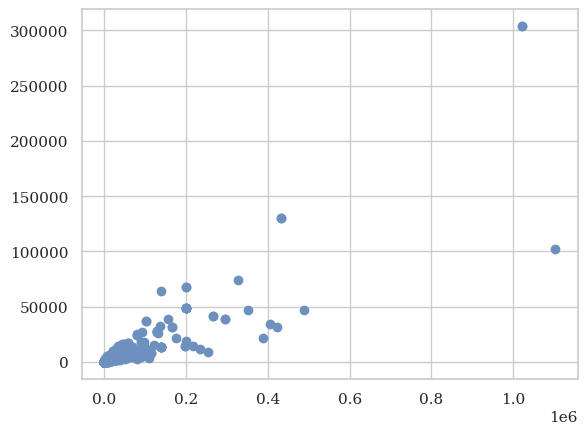

In [30]:
plt.scatter(us_tweets.favorite_count, us_tweets.retweet_count)

**Which party members have more retweets on their likes and posts on average?**

In [31]:
us_tweets['retweet_count'] = pd.to_numeric(us_tweets["retweet_count"])
us_tweets['favorite_count'] = pd.to_numeric(us_tweets["favorite_count"])

<AxesSubplot: xlabel='political_party', ylabel='retweet_count_sqrt'>

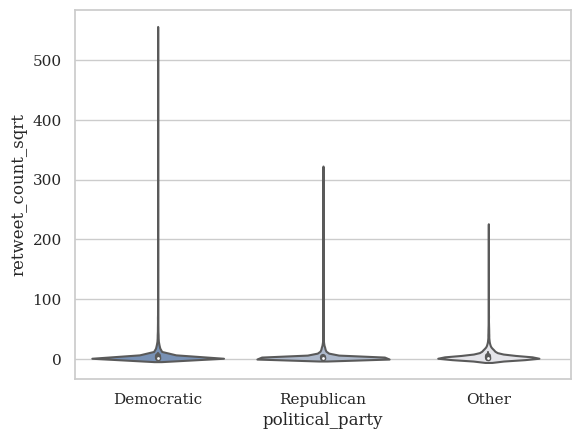

In [32]:
us_tweets['retweet_count_sqrt'] = np.sqrt(us_tweets['retweet_count'])
sns.violinplot(data=us_tweets[['retweet_count_sqrt', 'political_party']], y='retweet_count_sqrt', x = 'political_party')

<AxesSubplot: xlabel='political_party', ylabel='favorite_count_sqrt'>

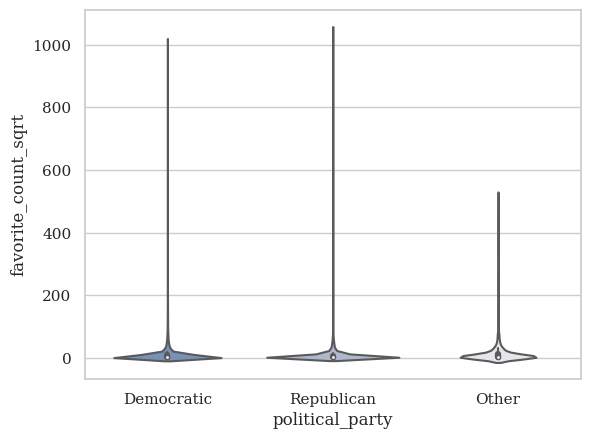

In [33]:
us_tweets['favorite_count_sqrt'] = np.sqrt(us_tweets['favorite_count'])
sns.violinplot(data=us_tweets[['favorite_count_sqrt', 'political_party']], y='favorite_count_sqrt', x = 'political_party')

**Let's draw the word clouds to see the most commonly used words.**

Top words for Republicans


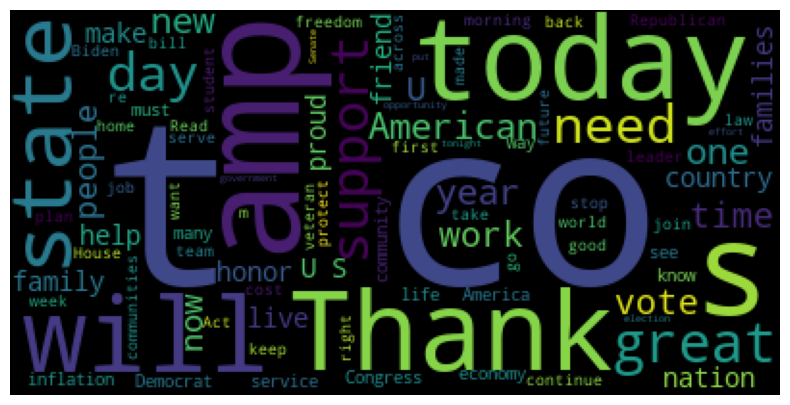

Top words for Democrats


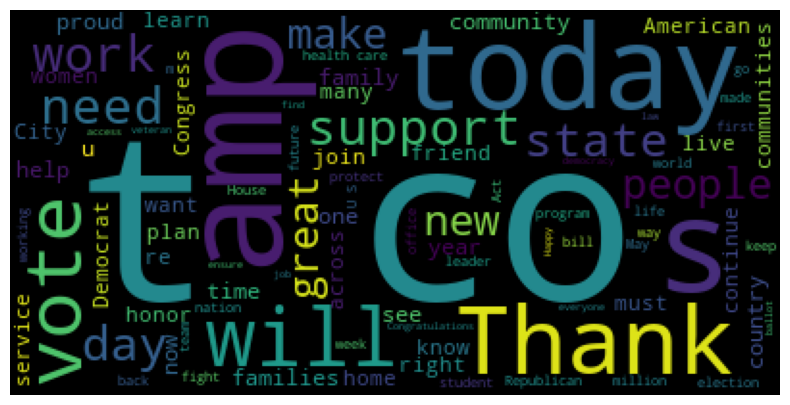

Top words for Others


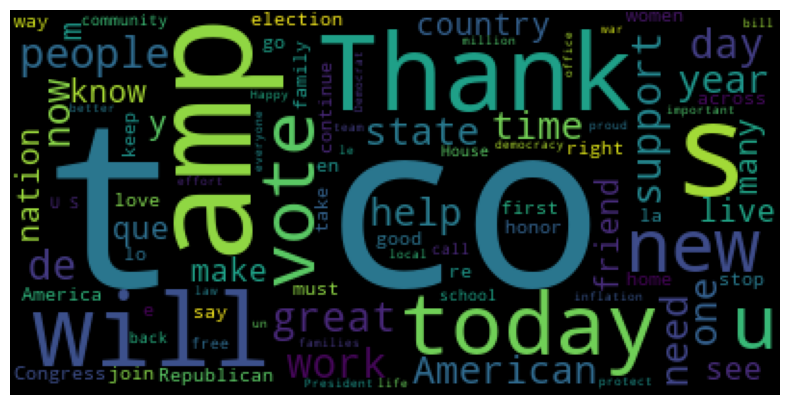

In [34]:
STOPWORDS.update(['https', 'ht', 'tps'])
plt.figure( figsize=(10,5) )
text = " ".join(review for review in us_tweets[us_tweets.political_party=='Republican'].text.dropna().astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS,max_words=90).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
print('Top words for Republicans')
plt.show()
gc.collect()

plt.figure( figsize=(10,5) )
text = " ".join(review for review in us_tweets[us_tweets.political_party=='Democratic'].text.dropna().astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS,max_words=90).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
print('Top words for Democrats')
plt.show()

plt.figure( figsize=(10,5) )
text = " ".join(review for review in us_tweets[us_tweets.political_party=='Other'].text.dropna().astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS,max_words=90).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
print('Top words for Others')
plt.show()

In [35]:
#mentions dataset: how many times one politician (by) has mentioned another (who)
mentions = pd.DataFrame(columns=['by', 'who'])

**Now let's generated a dataset from which we will be able to generate a graph. We have already created, and now it's time to fill it with data.**

In [36]:
count = 0
us_politicians = set(df.Twitter_username)
def generate_mentions(author,mentions_list):
    global mentions, count,us_politicians
    count+=1
    if count%500==0:
        print(count)
    for el in mentions_list:
        if el['screen_name'] in us_politicians:
            new_dict = {'by': author, 'who': el['screen_name']}
            mentions = mentions.append(new_dict, ignore_index=True)
    
    
us_tweets.apply(lambda x: generate_mentions(x.author, x.user_mentions),axis=1)

C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.append(new_dict, ignore_index=True)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.append(new_dict, ignore_index=True)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.append(new_dict, ignore_index=True)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.appe

500
1000
1500
2000
2500
3000
3500
4000
4500
5000


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.append(new_dict, ignore_index=True)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.append(new_dict, ignore_index=True)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.append(new_dict, ignore_index=True)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.appe

5500
6000
6500
7000
7500
8000
8500
9000
9500


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.append(new_dict, ignore_index=True)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.append(new_dict, ignore_index=True)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.append(new_dict, ignore_index=True)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.appe

10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.append(new_dict, ignore_index=True)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.append(new_dict, ignore_index=True)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.append(new_dict, ignore_index=True)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.appe

26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000


C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.append(new_dict, ignore_index=True)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.append(new_dict, ignore_index=True)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.append(new_dict, ignore_index=True)
C:\Users\jonch\AppData\Local\Temp\ipykernel_2388\1243323749.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mentions = mentions.appe

32500


0    None
1    None
2    None
3    None
4    None
     ... 
2    None
3    None
4    None
5    None
6    None
Length: 32973, dtype: object

In [37]:
mentions

,by,who
0,RepMcEachin,POTUS
1,RepMichlewitz,SenRodrigues
2,RepMichlewitz,VP
3,RepMichlewitz,RonMariano
4,Abby4Iowa,Axne4Congress
...,...,...
2492,RepZoeLofgren,POTUS
2493,RepZoeLofgren,RepRoKhanna
2494,RepZoeLofgren,RepAnnaEshoo
2495,RepZoeLofgren,RepJimmyPanetta


**Now let's count how many times each politician mentioned another politician**

In [38]:
mentions=mentions.groupby(['by','who']).size().reset_index().rename(columns={0:'Count'})

# Analysis.

**Let's create the network first**

In [39]:
G = nx.from_pandas_edgelist(mentions,'by','who', create_using=nx.DiGraph())
print('Accounts that have metioned someone at least ones or have been mentioned at least ones =',G.number_of_nodes())
#let's add the other users to the graph
G.add_nodes_from(us_tweets.author)
print('Total mentions between accounts:maximum possible mentions between accounts (which proportion of politicians have mentioned each other at least once)',
      G.number_of_edges(), ':', G.number_of_nodes()*(G.number_of_nodes()-1))

Accounts that have metioned someone at least ones or have been mentioned at least ones = 1008
Total mentions between accounts:maximum possible mentions between accounts (which proportion of politicians have mentioned each other at least once) 1443 : 2908730


**And now let's set the node attribute(political party) and edge attributes (times mentioned)**

In [40]:
usernames = df.Twitter_username
political_party = df.Political_party
attrs = {node:party for node,party in zip(usernames,political_party)}
nx.set_node_attributes(G, attrs,"Party")
nx.set_edge_attributes(G,{(author,to):times for author,to,times in zip(mentions.by,mentions.who,mentions.Count)},'Times Mentioned')
gc.collect()

5665

**What is the clustering coeficient? What is the transitivity?**

In [41]:
print('Average clustering coeficient', nx.average_clustering(G))
print('Transitivity', nx.transitivity(G))

Average clustering coeficient 0.02023719726150445
Transitivity 0.04530313124583611


**Surprisingly, the transitivity and average clustering coeficients are very low. Are these metrics different for Democrats and Republicans?**

In [42]:
D = G.subgraph([node[0] for node in G.nodes(data=True) if node[1]['Party']=='Democratic'])
R = G.subgraph([node[0] for node in G.nodes(data=True) if node[1]['Party']=='Republican'])
print('N Democrats',D.number_of_nodes(), 'N Republicans', R.number_of_nodes())
print('Average clustering coeficient democrats only', nx.average_clustering(D))
print('Transitivity democrats only', nx.transitivity(D))
print('Average clustering coeficient republicans only', nx.average_clustering(R))
print('Transitivity republicans only', nx.transitivity(R))

N Democrats 873 N Republicans 718
Average clustering coeficient democrats only 0.022780310855678214
Transitivity democrats only 0.06316916488222699
Average clustering coeficient republicans only 0.012112608517552805
Transitivity republicans only 0.038461538461538464


**Now let's draw the network**

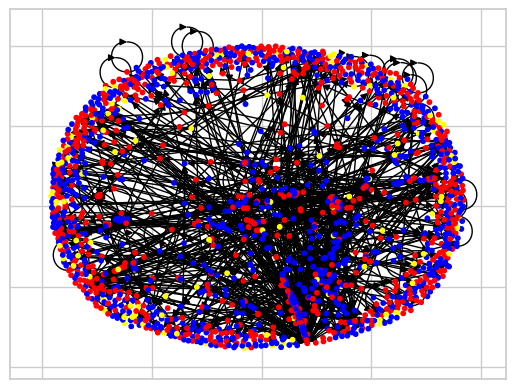

In [44]:
colors = []
for el in G.nodes(data="Party"):
    if el[1] == 'Republican':
        colors.append('red')
    elif el[1] == 'Democratic':
        colors.append('blue')
    else:
        colors.append('yellow')
    
nx.draw_networkx(G, node_size=10, node_color = colors, with_labels=False)

**What are the central nodes?**

Let's find the nodes with the largest page ranks!

page ranks with alpha=0
[('AGBecerra', 0.0005861664712778429), ('Rendon63rd', 0.0005861664712778429), ('AGDougPeterson', 0.0005861664712778429), ('GovRicketts', 0.0005861664712778429), ('Abby4Iowa', 0.0005861664712778429), ('Axne4Congress', 0.0005861664712778429), ('AjaLBrown', 0.0005861664712778429), ('MichaelDTubbs', 0.0005861664712778429), ('AlvedaCKing', 0.0005861664712778429), ('seanhannity', 0.0005861664712778429), ('AlyssaMastro44', 0.0005861664712778429), ('jonfavs', 0.0005861664712778429), ('AmbCMBraun', 0.0005861664712778429), ('JoeBiden', 0.0005861664712778429), ('KamalaHarris', 0.0005861664712778429), ('AmbDennisRoss', 0.0005861664712778429), ('AndrewGillum', 0.0005861664712778429), ('AngieCraigMN', 0.0005861664712778429), ('amyklobuchar', 0.0005861664712778429), ('AnnRomney', 0.0005861664712778429)]

Nodes with page rank of 0.0005847953216374269: total nodes 0 : 1706


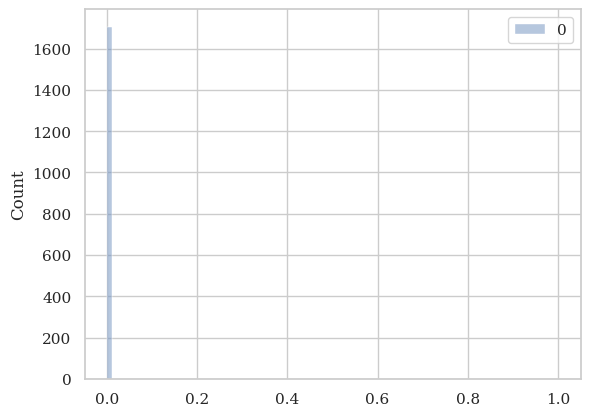

In [46]:
print('page ranks with alpha=0')
dic = nx.pagerank(G,alpha=0,max_iter=1000)
dic2=dict(sorted(dic.items(),key= lambda x:x[1]),reverse=True)
print(list(dic2.items())[0:20])
sns.histplot(dic2.values(), binwidth=0.01)
print('\nNodes with page rank of 0.0005847953216374269: total nodes',len([val for val in dic2.values() if val == 0.0005847953216374269]),':',G.number_of_nodes())

Surprisingly,all the nodes in the network have the same page rank with alpha=0. This means that the probability to reach any account while surfing the network is the same.

Which nodes have most in-directed edges (e.g. who are the most mentioned politicians)?

top mentioned accounts:
[('POTUS', 170), ('SpeakerPelosi', 89), ('realDonaldTrump', 46), ('JoeBiden', 39), ('VP', 34), ('BarackObama', 21), ('KamalaHarris', 19), ('HillaryClinton', 16), ('GovernorVA', 11), ('SenMarkey', 10), ('Sen_JoeManchin', 10), ('amyklobuchar', 8), ('CoryBooker', 8), ('ChuckGrassley', 8), ('seanhannity', 7), ('Tony4WI', 7), ('RonMariano', 7), ('BernieSanders', 7), ('SenWarren', 6), ('BetoORourke', 6), ('ChrisVanHollen', 6), ('RonDeSantisFL', 6), ('BillClinton', 6), ('TXRandy14', 6), ('RepJimBanks', 6), ('MichelleObama', 5), ('DanPatrick', 5), ('RepKClark', 5), ('KimReynoldsIA', 5), ('ewarren', 5), ('millermeeks', 5), ('timkaine', 5), ('GavinNewsom', 5), ('JohnCornyn', 5), ('senrobportman', 5), ('GovWhitmer', 5), ('RepGallagher', 5), ('RepRoKhanna', 5), ('CaptMarkKelly', 4), ('SenSchumer', 4), ('RepLeeZeldin', 4), ('MarkWarner', 4), ('KarenSpilka', 4), ('ChrisMurphyCT', 4), ('RepJeffDuncan', 4), ('GovBillLee', 4), ('KarlRove', 4), ('SenCapito', 4), ('GovMurphy', 4),

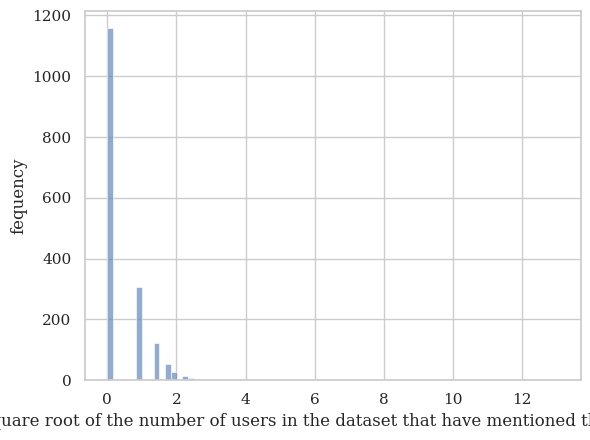

In [47]:
dic = G.in_degree()
#dic2=dict(sorted(dic,key= lambda x:x[1]), reverse=True)
print('top mentioned accounts:')
print(sorted(list(dic),reverse=True,key=lambda x:x[1])[0:50])
sns.histplot(np.sqrt([el[1] for el in list(dic)]))
plt.xlabel('square root of the number of users in the dataset that have mentioned this account')
plt.ylabel('fequency')
plt.show()

Which nodes have most out-directed edges (e.g. which politicians have mentioned the others most time)?

accounts that tend to mention most of other accounts
[('RepBillJohnson', 16), ('RodneyDavis', 12), ('CharlieBakerMA', 11), ('MarcRPacheco', 10), ('CongBillPosey', 8), ('DonBlankenship', 8), ('JoinTravisAllen', 8), ('LadySunshineNM', 8), ('PerkinsForUSSen', 8), ('SenatorStrange', 8), ('EFillerCorn', 7), ('GinaRaimondo', 7), ('GreenfieldIowa', 7), ('RepSteveStivers', 7), ('RealBartStupak', 7), ('SenJohnMccain', 7), ('marksmithiowa', 7), ('CarolynDykema', 6), ('EleanorNorton', 6), ('willjawando', 6), ('JoyceCraigNH', 6), ('RepGregMurphy', 6), ('SenStan', 6), ('TomDaschle', 6), ('BarackObama', 5), ('EileenDonoghue', 5), ('RepLawrence', 5), ('EvanMGlass', 5), ('LuisGutierrez', 5), ('MaliaCohen', 5), ('RepCummings', 5), ('RepHolding', 5), ('RepMikeHonda', 5), ('RepWalberg', 5), ('RicardoLara4CA', 5), ('RossSpano', 5), ('SenChrisDodd', 5), ('asolg', 5), ('billhaslam', 5), ('ericgarcetti', 5), ('marthacoakley', 5), ('repbarbaralee', 5), ('revrubendiaz', 5), ('amyklobuchar', 4), ('gregstantonaz

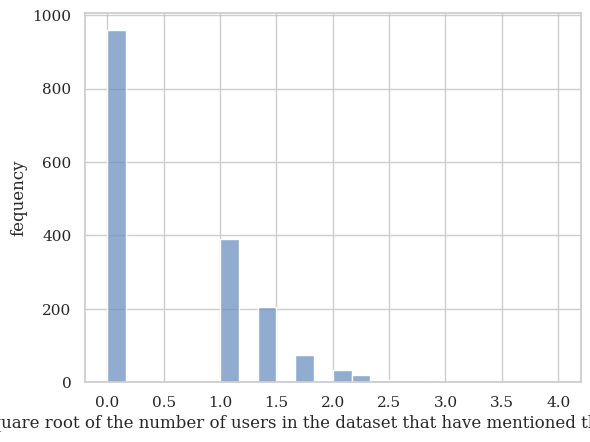

In [48]:
dic = G.out_degree()
#dic2=dict(sorted(dic,key= lambda x:x[1]), reverse=True)
print('accounts that tend to mention most of other accounts')
print(sorted(list(dic),reverse=True,key=lambda x:x[1])[0:50])
sns.histplot(np.sqrt([el[1] for el in list(dic)]))
plt.xlabel('square root of the number of users in the dataset that have mentioned this account')
plt.ylabel('fequency')
plt.show()

Which nodes have the highest closeness centrality (e.g. from which nodes it is easiest to get to the other nodes using only edges (mentions) presented in the dataset)?

Accounts:
[('POTUS', 0.1072804969866574), ('SpeakerPelosi', 0.06319681957020853), ('GerryConnolly', 0.04316123481687743), ('RepHuffman', 0.042228739002932544), ('VP', 0.03335407758948759), ('RepKatiePorter', 0.03223112234852802), ('RepGarretGraves', 0.032189023098114), ('JoeBiden', 0.026432062561094816), ('realDonaldTrump', 0.025205459614061766), ('BarackObama', 0.024355024314191318), ('staceyabrams', 0.01710089430697269), ('Tony4WI', 0.01695195524952524), ('RashidaTlaib', 0.016765432399216365), ('MichelleObama', 0.01665841489888411), ('SanfordBishop', 0.01643206256109482), ('ChrisMurphyCT', 0.013454873572175625), ('KamalaHarris', 0.012568077084206118), ('tammybaldwin', 0.010949781052062721), ('HillaryClinton', 0.010066431264587948), ('senrobportman', 0.00992002132764596), ('Sen_JoeManchin', 0.00924629054142776), ('RepRoKhanna', 0.009221859495748722), ('SenSherrodBrown', 0.008701241312818865), ('SenWhitehouse', 0.008056459669362897), ('SenatorCardin', 0.007964980628036902), ('GovernorV

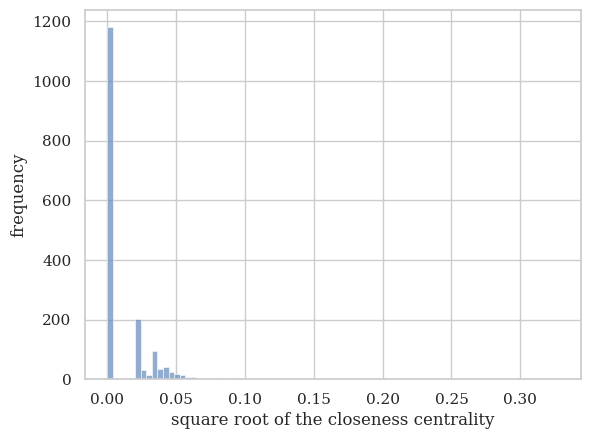

In [49]:
dic = nx.closeness_centrality(G)
print('Accounts:')
#print(dic)
print(sorted(list(dic.items()),reverse=True,key=lambda x:x[1])[0:50])
sns.histplot(np.sqrt([el[1] for el in list(dic.items())]))
plt.xlabel('square root of the closeness centrality')
plt.ylabel('frequency')
plt.show()

Which nodes have the highest betweenness centrality? (e.g. which nodes are included in most shortest paths)?

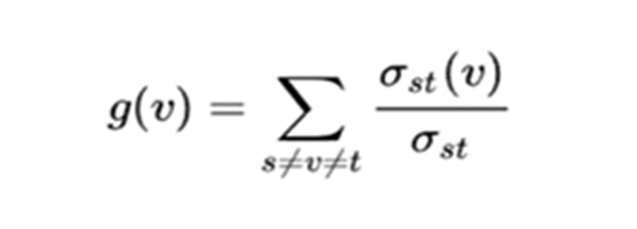

Accounts:
[('SpeakerPelosi', 0.0003199877007237298), ('BarackObama', 0.00020324783500612668), ('RepRoKhanna', 0.0001402599369432627), ('RepHuffman', 0.00010704500709044098), ('KamalaHarris', 9.792380873707543e-05), ('SenWhitehouse', 9.155617969793344e-05), ('SenBlumenthal', 8.277917750884584e-05), ('GerryConnolly', 7.813252929109357e-05), ('LindseyGrahamSC', 7.692784271612077e-05), ('seanhannity', 6.0750622995057336e-05), ('Tony4WI', 5.989013258436248e-05), ('amyklobuchar', 5.1457326559552815e-05), ('SenJackReed', 4.7843266834634394e-05), ('RepGallagher', 4.5950187931105694e-05), ('SenSherrodBrown', 3.95825588919637e-05), ('ChrisMurphyCT', 3.8549970399129866e-05), ('MichelleObama', 3.218234135998788e-05), ('RepJimBanks', 2.547051615656795e-05), ('senrobportman', 2.5126319992290003e-05), ('SpeakerRyan', 2.340533917090028e-05), ('MarkWarner', 2.3118509034001986e-05), ('SenatorDurbin', 2.3061143006622333e-05), ('LuisGutierrez', 2.2716946842344388e-05), ('RepLarryBucshon', 2.23727506780664

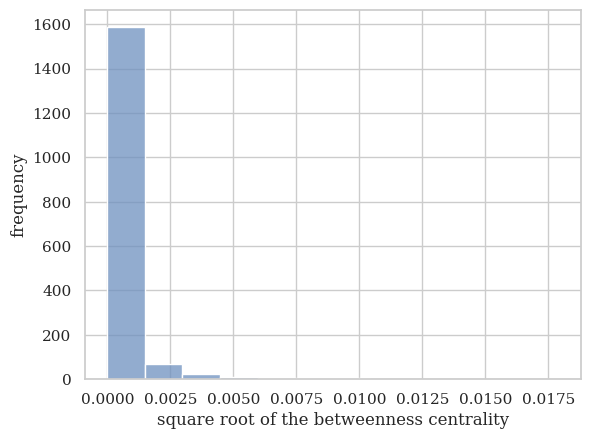

In [50]:
dic = nx.betweenness_centrality(G)
print('Accounts:')
#print(dic)
print(sorted(list(dic.items()),reverse=True,key=lambda x:x[1])[0:50])
sns.histplot(np.sqrt([el[1] for el in list(dic.items())]))
plt.xlabel('square root of the betweenness centrality')
plt.ylabel('frequency')
plt.show()

**What is the diameter ( the length of the longest shortest path) of the network?**

In [51]:
try:
    print('The diameter is', nx.diameter(G))
except:
    print('The graph is not strong, so the diameter can not be calculated.')

The graph is not strong, so the diameter can not be calculated.


**What are the strongly connected components (groups in which you can get from any node to any another node) in the graph? How many of them are there?**

In [52]:
print('number of strongly connected components is', nx.number_strongly_connected_components(G))
print('largest strongly connected component',max(nx.strongly_connected_components(G), key=len))

number of strongly connected components is 1671
largest strongly connected component {'GerryConnolly', 'RepKatiePorter', 'RepHuffman', 'SpeakerPelosi'}


**What is the distribution of the sizes of the strongly connected components?**

<AxesSubplot: ylabel='Count'>

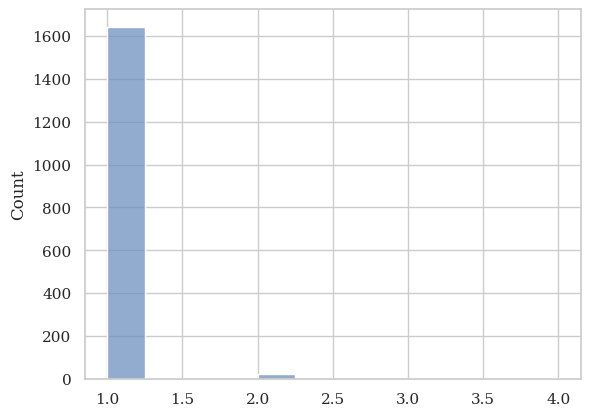

In [53]:
sns.histplot([len(x) for x in nx.strongly_connected_components(G)])

**How many weakly connected components (components in which you can get from any node to any another node if you ignore the directions of the edges) are there?**

In [54]:
print('number of weakly connected components is', nx.number_weakly_connected_components(G))
print('largest weakly connected component',max(nx.weakly_connected_components(G), key=len))
print('The largest weakly connected component size',max([len(el) for el in nx.weakly_connected_components(G)]))

number of weakly connected components is 759
largest weakly connected component {'MarkSicklesVA', 'RepRiggleman', 'jerrybrowngov', 'SenGillibrand', 'Denis44', 'winniebrinks', 'KalPenn', 'RepSusieLee', 'SenToomey', 'SenRonJohnson', 'SecBrouillette', 'RepMullin', 'corygardner', 'JebBush', 'SpeakerDeLeo', 'RashidaTlaib', 'janekim', 'RepJasonSmith', 'RepJoshG', 'RandyFeenstra', 'georgeallenva', 'RosLehtinen', 'SenBlumenthal', 'governorpataki', 'MitchLandrieu', 'RepGraceMeng', 'RepTedYoho', 'RepStephMurphy', 'PauletteEJordan', 'sharicedavids', 'mikegatto', 'RepDelBene', 'RonWyden', 'RepAngieCraig', 'PhilBredesen', 'Cline4Virginia', 'SenEvanBayh', 'senatorbarb', 'RepMichlewitz', 'RepMcEachin', 'SteveBenjaminSC', 'MayorPugh50', 'RepGoodlatte', 'SenDanSullivan', 'RepStefanik', 'JohnKasich', 'QuirkSilva65th', 'marcussimon', 'govmikehuckabee', 'AndyBeshearKY', 'Psaki44', 'RepStephenLynch', 'mayor_steinberg', 'RepSusanWild', 'RepPaulMitchell', 'RepHarrington', 'PatTiberi', 'DanaJWachs', 'RepJoeCo

**What is the distributions of the sizes of the weakly connected components**

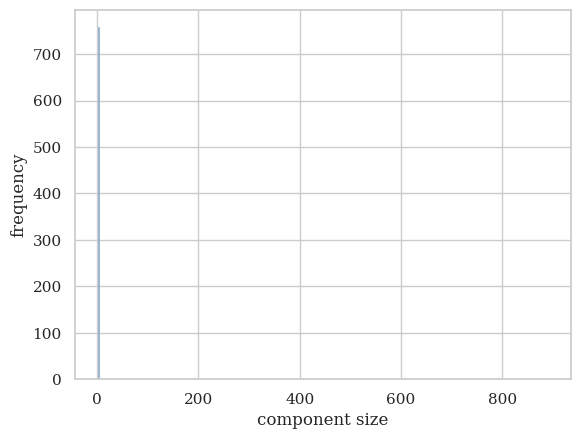

In [55]:
sns.histplot([len(x) for x in nx.weakly_connected_components(G)],binwidth=5)
plt.xlabel('component size')
plt.ylabel('frequency')
plt.show()

**We can see that there are many strongly and weakly connected components. Is the picture the same inside the political parties?**

number of weakly connected components in the Democrat network is 442
largest weakly connected component in the Democrat network {'MarkSicklesVA', 'jerrybrowngov', 'SenGillibrand', 'winniebrinks', 'RepSusieLee', 'SpeakerDeLeo', 'RashidaTlaib', 'janekim', 'SenBlumenthal', 'RepGraceMeng', 'PauletteEJordan', 'mikegatto', 'RepDelBene', 'RonWyden', 'PhilBredesen', 'senatorbarb', 'RepMichlewitz', 'SteveBenjaminSC', 'MayorPugh50', 'marcussimon', 'AndyBeshearKY', 'Psaki44', 'mayor_steinberg', 'DanaJWachs', 'RepStephenLynch', 'RepSusanWild', 'RepJoeCourtney', 'TishJames', 'SenatorBennet', 'RepDebDingell', 'SenatorHassan', 'nancy_navarro', 'TomDaschle', 'RepBera', 'GuamCongressman', 'MC_Council_Katz', 'KamalaHarris', 'dianesavino', 'kdeleon', 'SenBobCasey', 'senatorreid', 'RepMarcyKaptur', 'RepHankJohnson', 'CarolynDykema', 'Sen_JoeManchin', 'RepPeterDeFazio', 'edcoppinger', 'EileenDonoghue', 'arneduncan', 'RepSylviaGarcia', 'MarcRPacheco', 'HinojosaTX', 'Scott_Wiener', 'SanfordBishop', 'hildasol

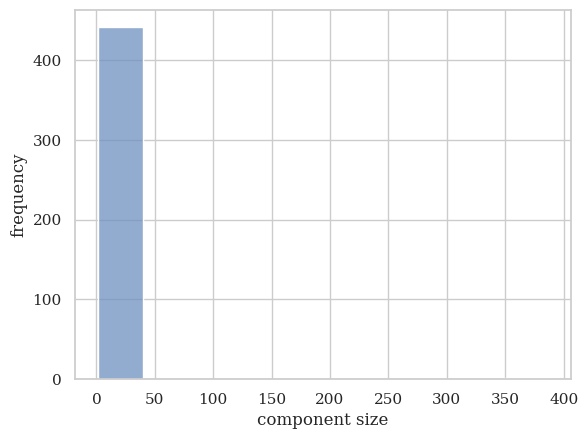

In [56]:
print('number of weakly connected components in the Democrat network is', nx.number_weakly_connected_components(D))
print('largest weakly connected component in the Democrat network',max(nx.weakly_connected_components(D), key=len))
sns.histplot([len(x) for x in nx.weakly_connected_components(D)])
plt.xlabel('component size')
plt.ylabel('frequency')
plt.show()

number of strongly connected components in the Democrat network is 852
largest strongly connected component in the Democrat network {'Tony4WI', 'BarackObama', 'MichelleObama', 'ChrisMurphyCT'}


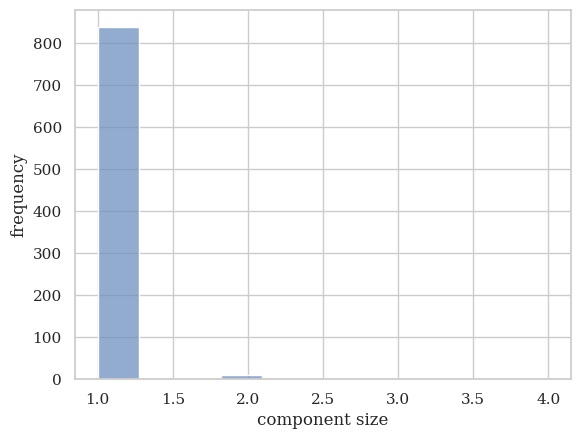

In [57]:
print('number of strongly connected components in the Democrat network is', nx.number_strongly_connected_components(D))
print('largest strongly connected component in the Democrat network',max(nx.strongly_connected_components(D), key=len))
sns.histplot([len(x) for x in nx.strongly_connected_components(D)])
plt.xlabel('component size')
plt.ylabel('frequency')
plt.show()

number of strongly connected components in the Republican network is 709
largest strongly connected component in the Republican network {'JonHusted', 'robportman', 'MikeDeWine'}


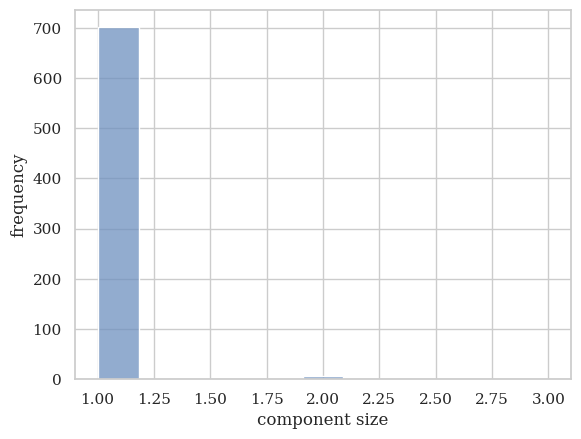

In [58]:
print('number of strongly connected components in the Republican network is', nx.number_strongly_connected_components(R))
print('largest strongly connected component in the Republican network',max(nx.strongly_connected_components(R), key=len))
sns.histplot([len(x) for x in nx.strongly_connected_components(R)])
plt.xlabel('component size')
plt.ylabel('frequency')
plt.show()

number of weakly connected components in the Republican network is 414
largest weakly connected component in the Republican network {'SenCapito', 'RepRiggleman', 'SecretaryCarson', 'RepHultgren', 'sentomcotton', 'ChuckGrassley', 'RepHartzler', 'RepHalRogers', 'SenRonJohnson', 'RepJohnCurtis', 'RepThomasMassie', 'SecBrouillette', 'RepMullin', 'JebBush', 'RepJasonSmith', 'KenCalvert', 'SecPriceMD', 'jebbush', 'RepJimBanks', 'RepCloudTX', 'sendavidperdue', 'IsraelOQuinn', 'RepTedYoho', 'SenatorFischer', 'SpencerJCox', 'RepLouieGohmert', 'justinamash', 'RepGarretGraves', 'TomColeOK04', 'RepArmstrongND', 'RepLarryBucshon', 'repkevinhern', 'mattgaetz', 'USRepGaryPalmer', 'MacTXPress', 'seanspicer', 'DunnCampaign', 'SteveKingIA', 'MarshaBlackburn', 'RepClayHiggins', 'SteveForbesCEO', 'RepGoodlatte', 'SenatorTimScott', 'stevenmnuchin1', 'VoteForTrey', 'SenDanSullivan', 'RepRutherfordFL', 'RepStefanik', 'RepPeteStauber', 'senrobportman', 'JohnKasich', 'BobLatta', 'RepChrisStewart', 'govmikehuck

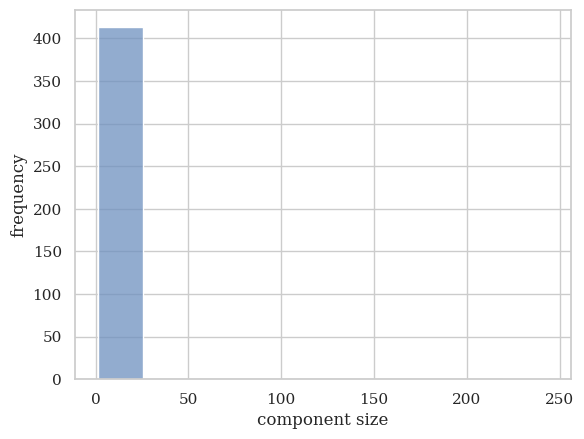

In [59]:
print('number of weakly connected components in the Republican network is', nx.number_weakly_connected_components(R))
print('largest weakly connected component in the Republican network',max(nx.weakly_connected_components(R), key=len))
sns.histplot([len(x) for x in nx.weakly_connected_components(R)])
plt.xlabel('component size')
plt.ylabel('frequency')
plt.show()

**What is the gini inequality index in the distribution of the mentions of the politicians?**

Gini inequality index: 0.6261681901493471


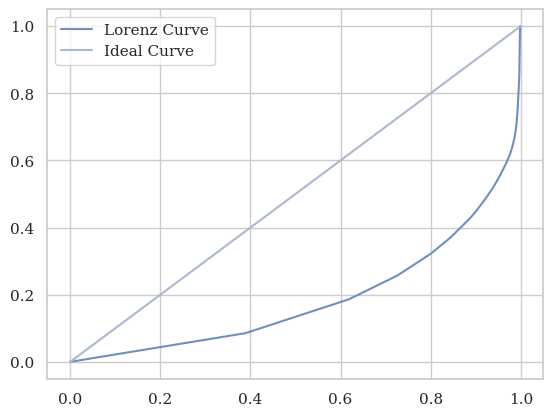

In [60]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))
#print(mentions.groupby('to')['count'].sum())
print('Gini inequality index:',gini(mentions.groupby('who')['Count'].sum()))

def gini_plot(array):
    array = sorted(array)
    x = [i/len(array) for i in range(len(array))]
    y = [sum(array[0:i+1])/sum(array) for i in range(len(array))]
    return x,y
    
plt.plot(gini_plot(mentions.groupby('who')['Count'].sum())[0],gini_plot(mentions.groupby('who')['Count'].sum())[1], label = "Lorenz Curve")
plt.plot([0,1],[0,1], label = 'Ideal Curve')
plt.legend(loc="upper left")
plt.show()

The gini index is unxepectedly high. It is higher thant the inequality index in any country.

**Which community is more connected: Republicans or Democrats?**

In [61]:
print('Existing edges in Democratic network: possible edges in Democratic network',D.number_of_edges(), ':', D.number_of_nodes()*(D.number_of_nodes()-1), D.number_of_edges()/ D.number_of_nodes()/(D.number_of_nodes()-1))
print('Existing edges in Republicans network: possible edges in Republicans network',R.number_of_edges(), ':', R.number_of_nodes()*(R.number_of_nodes()-1), R.number_of_edges()/ R.number_of_nodes()/(R.number_of_nodes()-1))

Existing edges in Democratic network: possible edges in Democratic network 588 : 761256 0.0007724077051609446
Existing edges in Republicans network: possible edges in Republicans network 384 : 514806 0.0007459120523070828


There are over twice as many edges within the two gorups as there are nodes between them!

# Conclusions

1) The distribution of mentions is very unequal

2) The average clustering and transitivity are very low

3) Surprisingly, the page ranks have uniform distribution

4) POTUS (248), JoeBiden (55), realDonaldTrump (46), SpeakerPelosi (23), GavinNewsom (15), KamalaHarris (14) have the highest in-degree centrality.

5) congressmanhice (52), RepRutherfordFL (16), CongBillPosey (12), CharlieBakerMA (11), RepMoolenaar (10) have the highest out-degree centrality

6) Nodes with the highest closeness centrality are POTUS, JoeBiden, realDonaldTrump, VP and SpeakerPelosi

7) Betwennes centrality values for all the nodes are really low. This indicates that most nodes are not included in many shortest paths.

8) The network is split into many small strong components

9) There are many weakly connected components. Most of them are very small, but the larges of them has size of 910

10) There are over twice as many edges within Democratic/Republican groups as there are between!

11) (Ratio existing number of connection by at least one mention) : (possible number of connections by at least one mention) is very low, and it is a bit higher for Republicans than For Democrats

